# Scalable CMA-MAE Tutorial using Sphere Benchmark

### Brief Explanation of Scalable CMA-MAE

A challenge with CMA-MAE is the quadratic time complexity associated with the computations required over an nxn matrix containing $n^2$ standard deviations.

To combat this problem, Scalable CMA-MAE utilizes different evolution strategies to decrease the number of computations required. Below are 3 evolution strategies described in [Tjanaka 2022](https://arxiv.org/abs/2210.02622).

<ul>
   <li> Limited Memory Matrix Adaptation ES (LM-MA-ES):
        <ul>
            <li>Approximates transformation matrix with $k$ $n$-dimensional vectors where $k << n$.</li>
            <li>Approximately $\theta(kn)$ runtime.</li>
        </ul>
   </li>
   <li> Seperable CMA-ES (sep-CMA-MAE):
        <ul>
            <li>Constrains covariance matrix to just a diaganol matrix of standard deviations.</li>
            <li>Approximately $\theta(n)$ runtime.</li>
        </ul>
   </li>
   <li> OpenAI ES (OpenAI-MAE):
        <ul>
            <li>Differs from CMA-ES but still represents search space with a gaussian.</li>
            <li>Approximately $\theta(n)$ runtime.</li>
        </ul>       
   </li>
</ul>

## Setup

In [1]:
%pip install ribs[visualize] tqdm


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

## The Sphere Linear Projection Benchmark

In [3]:
def sphere(solution_batch):
    """Sphere function evaluation and measures for a batch of solutions.

    Args:
        solution_batch (np.ndarray): (batch_size, dim) batch of solutions.
    Returns:
        objective_batch (np.ndarray): (batch_size,) batch of objectives.
        measures_batch (np.ndarray): (batch_size, 2) batch of measures.
    """
    dim = solution_batch.shape[1]

    # Shift the Sphere function so that the optimal value is at x_i = 2.048.
    sphere_shift = 5.12 * 0.4

    # Normalize the objective to the range [0, 100] where 100 is optimal.
    best_obj = 0.0
    worst_obj = (-5.12 - sphere_shift)**2 * dim
    raw_obj = np.sum(np.square(solution_batch - sphere_shift), axis=1)
    objective_batch = (raw_obj - worst_obj) / (best_obj - worst_obj) * 100

    # Calculate measures.
    clipped = solution_batch.copy()
    clip_mask = (clipped < -5.12) | (clipped > 5.12)
    clipped[clip_mask] = 5.12 / clipped[clip_mask]
    measures_batch = np.concatenate(
        (
            np.sum(clipped[:, :dim // 2], axis=1, keepdims=True),
            np.sum(clipped[:, dim // 2:], axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objective_batch, measures_batch

## Creating an Archive

In [4]:
from ribs.archives import GridArchive

max_bound = 100 / 2 * 5.12

archive = GridArchive(solution_dim=100,
                      dims=(100, 100),
                      ranges=[(-max_bound, max_bound), (-max_bound, max_bound)],
                      learning_rate=0.01,
                      threshold_min=0.0)

In [5]:
result_archive = GridArchive(solution_dim=100,
                             dims=(100, 100),
                             ranges=[(-max_bound, max_bound), (-max_bound, max_bound)])

## Create Evolution Strategy Emitters

Note the use of the evolution strategy (es) parameter. Here, you can input 2 scalable variants of CMA-ES and the OpenAI evolution strategy.
<ul>
    <li>Separable CMA-ES: "sep_cma_es"</li>
    <li>Limited Memory Matrix Adaptation ES: "lm_ma_es"</li>
    <li>OpenAI Evolution Strategy: "openai_es"</li>
</ul>
Here we use the seperable CMA-ES, "sep_cma_es".

In [6]:
from ribs.emitters import EvolutionStrategyEmitter

emitters = [
    EvolutionStrategyEmitter(
        archive,
        x0=np.zeros(100),
        sigma0=0.5,
        ranker="imp",
        es="sep_cma_es",
        selection_rule="mu",
        restart_rule="basic",
        batch_size=36
    ) for _ in range(15)
]

## Create a Scheduler

In [7]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters, result_archive=result_archive)

## Running Scalable CMA-MAE

Scalable CMA-MAE algorithm as described in [Tjanaka 2022](https://arxiv.org/abs/2210.02622).

In [8]:
total_itrs = 10_000

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    solution_batch = scheduler.ask()
    objective_batch, measure_batch = sphere(solution_batch)
    scheduler.tell(objective_batch, measure_batch)

    # Output progress every 500 iterations or on the final iteration.
    if itr % 500 == 0 or itr == total_itrs:
        tqdm.write(f"Iteration {itr:5d} | "
                   f"Archive Coverage: {result_archive.stats.coverage * 100:6.3f}%  "
                   f"Normalized QD Score: {result_archive.stats.norm_qd_score:6.3f}")

Iteration   500 | Archive Coverage: 59.900%  Normalized QD Score: 47.782                                                                                                               
Iteration  1000 | Archive Coverage: 68.770%  Normalized QD Score: 53.368                                                                                                               
Iteration  1500 | Archive Coverage: 74.860%  Normalized QD Score: 57.141                                                                                                               
Iteration  2000 | Archive Coverage: 77.170%  Normalized QD Score: 58.646                                                                                                               
Iteration  2500 | Archive Coverage: 80.610%  Normalized QD Score: 60.532                                                                                                               
Iteration  3000 | Archive Coverage: 81.500%  Normalized QD Score: 61.395        

## Visualization

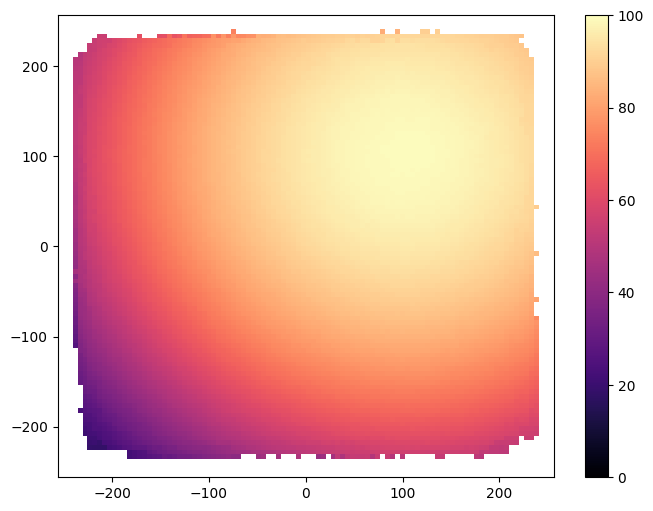

In [9]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(result_archive, vmin=0, vmax=100)

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_scalable_cma_mae,
  title   = {Upgrading CMA-ME to CMA-MAE on the Sphere Benchmark},
  author  = {David H. Lee and Bryon Tjanaka and Nivedit Reddy Balam and
             Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2023},
  url     = {https://docs.pyribs.org/en/stable/tutorials/cma_mae.html}
}
```